<a href="https://colab.research.google.com/github/errec-sun/brain/blob/master/%D0%9D%D0%BE%D1%8F%D0%B1%D1%80%D1%8C%D1%81%D0%BA%D0%B8_%D0%BA%D1%83%D1%80%D1%81_Pro_%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_7_%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%86%D0%B5%D0%BD%D1%8B_%D0%B1%D0%B5%D0%BD%D0%B7%D0%B8%D0%BD%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Теоретический материал с лекции:* https://youtu.be/1BV1I59HwB4?t=1614

In [0]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, CuDNNLSTM

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import load_model

Using TensorFlow backend.


In [0]:
#Загружаем файл базы
files.upload()
!ls

Saving 2004-2019.tsv to 2004-2019.tsv
2004-2019.tsv  sample_data


In [0]:
#Считываем данные с помощью pandas
#Для чтения tsv файла ставим sep='\t'
base_data = pd.read_csv('2004-2019.tsv', sep='\t')

In [0]:
print(base_data.iloc[:,9:12].head(20))

    DESVIO PADRÃO REVENDA  PREÇO MÍNIMO REVENDA  PREÇO MÁXIMO REVENDA
0                   0.016                 1.190                 1.350
1                   0.114                 0.890                 1.449
2                   0.097                 1.180                 1.760
3                   0.070                 1.090                 1.509
4                   0.078                 1.050                 1.400
5                   0.132                 0.999                 2.050
6                   0.218                 1.030                 1.950
7                   0.158                 1.350                 2.000
8                   0.130                 1.100                 1.699
9                   0.141                 0.989                 1.700
10                  0.134                 1.400                 1.780
11                  0.116                 1.090                 1.590
12                  0.109                 1.150                 1.750
13                  

In [0]:
#Группируем данные по неделе старта
#В исходных данных по каждой неделе данные по нескольким регионам страны
data2 = base_data.groupby('DATA INICIAL').mean()

#Оставляем колонки с 3 по 7
#В них нужные для нас числовые данные
data = data2.values[:,2:-1]
print(data.shape)

(785, 6)


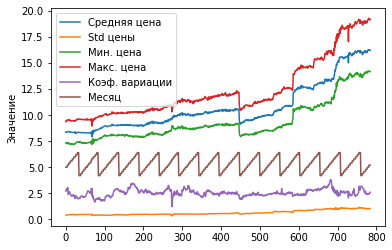

In [0]:
#Отображаем исходные от точки start и длинной step
start = 0
step = 785

#Подбираем смещения, чтобы удобно расположить графики на экране
koef = [1, 1, 1, 1, 100, 0.2]
bias = [0, 0, 0, 0, -2, 4]

#Заполняем текстовые названия каналов данных
chanelNames = ['Средняя цена', 'Std цены', 'Мин. цена', 'Макс. цена', 'Коэф. вариации', 'Месяц']

#Рисуем все графики данных
for i in range(data.shape[1]):
  plt.plot(koef[i]*data[start:start+step,i] + bias[i], 
          label=chanelNames[i])
plt.ylabel('Значение')
plt.legend()
plt.show()

**Функция загрузки данных**

*Разбор данного раздела:* https://youtu.be/1BV1I59HwB4?t=5359

In [0]:
def getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative):
  
  #Если указано превращение данных в производную
  #То вычитаем поточечно из текущей точки предыдущую
  if (convertToDerivative):
    data = np.array([(d[1:]-d[:-1]) for d in data.T]).copy().T
  
  #Выбираем тип нормализации x
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (xNormalization == 0):
    xScaler = StandardScaler()
  else:
    xScaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  xData = data[:,xChannels]
  #Обучаем нормировщик
  xScaler.fit(xData)
  #Нормируем данные
  xData = xScaler.transform(xData)

  #Выбираем тип нормализации y
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (yNormalization == 0):
    yScaler = StandardScaler()
  else:
    yScaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  yData = data[:,yChannels]
  #Обучаем нормировщик
  yScaler.fit(yData)
  #Нормируем данные
  yData = yScaler.transform(yData)

  #Формируем xTrain
  #Раскусываем исходный ряд на куски xLen с шагом в 1
  xTrain = np.array([xData[i:i+xLen, :] for i in range(xData.shape[0]-xLen-1-stepsForward)])
  
  #Формируем yTrain
  #Берём stepsForward шагов после завершения текущего x
  if (stepsForward > 0):
    yTrain = np.array([yData[i+xLen:i+xLen+stepsForward, :] for i in range(yData.shape[0]-xLen-1-stepsForward)])
  else:
    yTrain = np.array([yData[i+xLen+stepsForward, :] for i in range(yData.shape[0]-xLen-1-stepsForward)])

  #Делаем reshape y в зависимости от того
  #Прогнозируем на 1 шаг вперёдили на несколько
  if (stepsForward == 0):
    if ((len(yChannels) == 1)):
      yTrain = yTrain.reshape(yTrain.shape[0], 1)
  else:
      yTrain = yTrain.reshape(yTrain.shape[0], stepsForward)
  
  #Расчитыываем отступ между обучающими о проверочными данными
  #Чтобы они не смешивались
  xTrainLen = xTrain.shape[0]
  bias = xLen + stepsForward + 2

  #Берём из конечной части xTrain проверочную выборку
  xVal = xTrain[xTrainLen-valLen:]
  yVal = yTrain[xTrainLen-valLen:]
  #Оставшуюся часть используем под обучающую выборку
  xTrain = xTrain[:xTrainLen-valLen-bias]
  yTrain = yTrain[:xTrainLen-valLen-bias]

  #Если в функцию передали вернуть flatten сигнал (для Dense сети)
  #xTrain и xVal превращаем в flatten
  if (returnFlatten > 0):
    xTrain = np.array([x.flatten() for x in xTrain])
    xVal = np.array([x.flatten() for x in xVal])

  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

In [0]:
#Формируем параметры загрузки данных
xLen = 20
stepsForward = 0
xChannels = range(data.shape[1])
yChannels = [0]
xNormalization = 0
yNormalization = 0
valLen = 100
returnFlatten = 1
convertToDerivative = 0

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(642, 120)
(642, 1)
(100, 120)
(100, 1)


#Полносвязная сеть

*Разбор данного раздела:* https://youtu.be/1BV1I59HwB4?t=5406








Train on 642 samples, validate on 100 samples
Epoch 1/200





642/642 [==============================] - 5s 7ms/step - loss: 2.0818 - val_loss: 3.1468
Epoch 2/200
642/642 [==============================] - 0s 256us/step - loss: 1.3890 - val_loss: 2.3344
Epoch 3/200
642/642 [==============================] - 0s 231us/step - loss: 0.9655 - val_loss: 1.8945
Epoch 4/200
642/642 [==============================] - 0s 226us/step - loss: 0.6948 - val_loss: 1.5161
Epoch 5/200
642/642 [==============================] - 0s 241us/step - loss: 0.5109 - val_loss: 1.1478
Epoch 6/200
642/642 [==============================] - 0s 223us/step - loss: 0.3890 - val_loss: 0.9011
Epoch 7/200
642/642 [==============================] - 0s 237us/step - loss: 0.3089 - val_loss: 0.6838
Epoch 8/200
642/642 [==============================] - 0s 263us/step - loss: 0.2531 - val_loss: 0.5607
Epoch 9/200
642/642 [==============================] - 0s 232us/step - loss: 0.2134 - val_loss: 0.4594
Epoch 10/200
642/

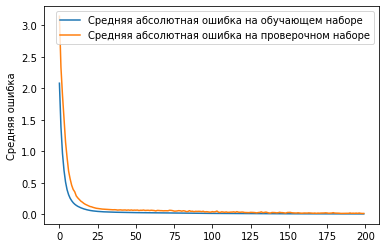

In [0]:
modelD = Sequential()

modelD.add(Dense(100, input_dim = xTrain.shape[1], activation="linear"))
modelD.add(Dense(100, activation="linear"))
modelD.add(Dense(100, activation="linear"))
modelD.add(Dense(yTrain.shape[1], activation="linear"))

modelD.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelD.fit(xTrain, 
                    yTrain, 
                    epochs=200,
                    batch_size=20, 
                    verbose=1, 
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

#Визуализация результатов

*Разбор данного раздела:* https://youtu.be/1BV1I59HwB4?t=5451

In [0]:
#Функция рассчитываем результаты прогнозирования сети
#В аргументы принимает сеть (currModel) и проверочную выборку
#Выдаёт результаты предсказания predVal
#И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
#Функция расчёта корреляции дух одномерных векторов
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

#Функция рисуем корреляцию прогнозированного сигнала с правильным
#Смещая на различное количество шагов назад
#Для проверки появления эффекта автокорреляции
#channels - по каким каналам отображать корреляцию
#corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0]

    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    plt.plot(corr, 
               label='предсказание на ' + str(ch+1) + ' шаг')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [0]:
#Прогнозируем данные текущей сетью
currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

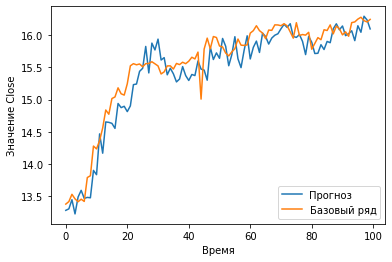

In [0]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

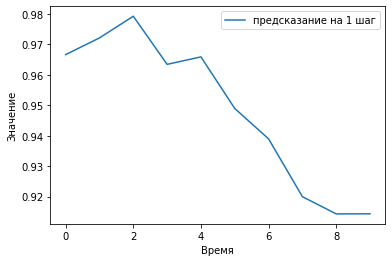

In [0]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

#Одномерная свёртка

*Разбор данного раздела:* https://youtu.be/1BV1I59HwB4?t=5556

In [0]:
#Формируем параметры загрузки данных
xLen = 20
stepsForward = 0
xChannels = range(data.shape[1])
yChannels = [0]
xNormalization = 0
yNormalization = 0
valLen = 100
returnFlatten = 0
convertToDerivative = 0

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(642, 20, 6)
(642, 1)
(100, 20, 6)
(100, 1)


Train on 642 samples, validate on 100 samples
Epoch 1/80
642/642 [==============================] - 1s 2ms/step - loss: 0.0329 - val_loss: 0.0640
Epoch 2/80
642/642 [==============================] - 0s 231us/step - loss: 0.0193 - val_loss: 0.0227
Epoch 3/80
642/642 [==============================] - 0s 230us/step - loss: 0.0143 - val_loss: 0.0209
Epoch 4/80
642/642 [==============================] - 0s 236us/step - loss: 0.0112 - val_loss: 0.0178
Epoch 5/80
642/642 [==============================] - 0s 227us/step - loss: 0.0090 - val_loss: 0.0158
Epoch 6/80
642/642 [==============================] - 0s 225us/step - loss: 0.0087 - val_loss: 0.0200
Epoch 7/80
642/642 [==============================] - 0s 237us/step - loss: 0.0064 - val_loss: 0.0161
Epoch 8/80
642/642 [==============================] - 0s 239us/step - loss: 0.0054 - val_loss: 0.0112
Epoch 9/80
642/642 [==============================] - 0s 225us/step - loss: 0.0047 - val_loss: 0.0131
Epoch 10/80
642/642 [=================

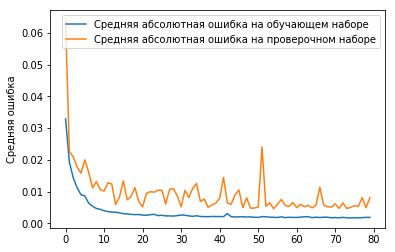

In [0]:
modelC = Sequential()

modelC.add(Conv1D(50, 10, padding="same", input_shape = (xTrain.shape[1], xTrain.shape[2]), activation="linear"))
modelC.add(Conv1D(100, 10, padding="same", activation="linear"))
modelC.add(Conv1D(100, 10, padding="same", activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(10, activation="linear"))
modelC.add(Dense(yTrain.shape[1], activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelC.fit(xTrain, 
                    yTrain, 
                    epochs=80, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [0]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

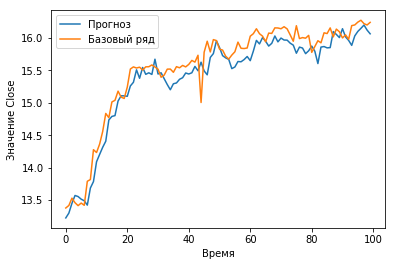

In [0]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

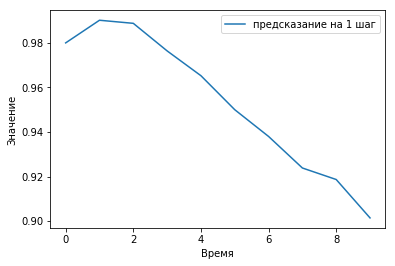

In [0]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

#LSTM

*Разбор данного раздела:* https://youtu.be/1BV1I59HwB4?t=5629

Train on 642 samples, validate on 100 samples
Epoch 1/100
642/642 [==============================] - 2s 3ms/step - loss: 0.3430 - val_loss: 3.2911
Epoch 2/100
642/642 [==============================] - 0s 520us/step - loss: 0.1780 - val_loss: 2.0630
Epoch 3/100
642/642 [==============================] - 0s 472us/step - loss: 0.0762 - val_loss: 1.2208
Epoch 4/100
642/642 [==============================] - 0s 469us/step - loss: 0.0410 - val_loss: 0.8391
Epoch 5/100
642/642 [==============================] - 0s 493us/step - loss: 0.0306 - val_loss: 0.6507
Epoch 6/100
642/642 [==============================] - 0s 460us/step - loss: 0.0243 - val_loss: 0.4960
Epoch 7/100
642/642 [==============================] - 0s 461us/step - loss: 0.0202 - val_loss: 0.3791
Epoch 8/100
642/642 [==============================] - 0s 469us/step - loss: 0.0180 - val_loss: 0.3030
Epoch 9/100
642/642 [==============================] - 0s 460us/step - loss: 0.0167 - val_loss: 0.2676
Epoch 10/100
642/642 [=======

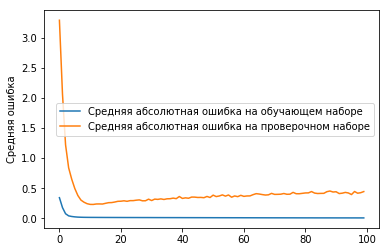

In [0]:
modelL = Sequential()
#modelL.add(CuDNNLSTM(100, input_shape = (xTrain.shape[1], xTrain.shape[2])))
modelL.add(CuDNNLSTM(100, input_shape = (xTrain.shape[1], xTrain.shape[2]), return_sequences="True"))
modelL.add(CuDNNLSTM(100, return_sequences="True"))
modelL.add(CuDNNLSTM(100, return_sequences="True"))
modelL.add(Flatten())
modelL.add(Dense(100, activation="linear"))
modelL.add(Dense(yTrain.shape[1], activation="linear"))

modelL.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelL.fit(xTrain, 
                    yTrain, 
                    epochs=100, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [0]:
#Прогнозируем данные текущей сетью
currModel = modelL
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

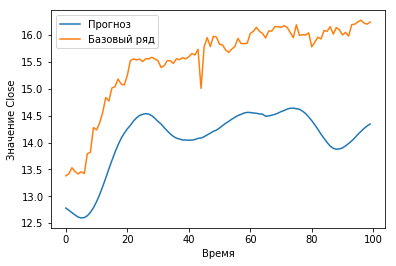

In [0]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

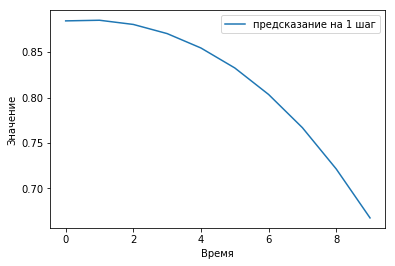

In [0]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

#ModelX
**Сложная сеть из LSTM и Conv1D слоёв на старте и Dense слоёв в конце**

*Разбор данного раздела:* https://youtu.be/1BV1I59HwB4?t=5704

Train on 642 samples, validate on 100 samples
Epoch 1/60
642/642 [==============================] - 2s 3ms/step - loss: 0.1414 - val_loss: 0.8574
Epoch 2/60
642/642 [==============================] - 0s 575us/step - loss: 0.0201 - val_loss: 0.1808
Epoch 3/60
642/642 [==============================] - 0s 562us/step - loss: 0.0156 - val_loss: 0.2576
Epoch 4/60
642/642 [==============================] - 0s 596us/step - loss: 0.0134 - val_loss: 0.2377
Epoch 5/60
642/642 [==============================] - 0s 582us/step - loss: 0.0118 - val_loss: 0.2297
Epoch 6/60
642/642 [==============================] - 0s 574us/step - loss: 0.0106 - val_loss: 0.2278
Epoch 7/60
642/642 [==============================] - 0s 566us/step - loss: 0.0097 - val_loss: 0.1762
Epoch 8/60
642/642 [==============================] - 0s 590us/step - loss: 0.0090 - val_loss: 0.1989
Epoch 9/60
642/642 [==============================] - 0s 587us/step - loss: 0.0084 - val_loss: 0.1735
Epoch 10/60
642/642 [=================

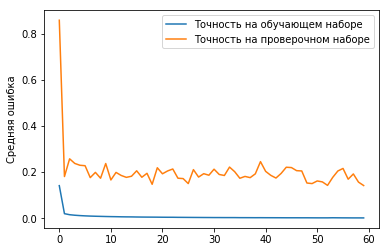

In [0]:
dataInput = Input(shape=(xTrain.shape[1], xTrain.shape[2]))

lstmWay = CuDNNLSTM(100, return_sequences="True")(dataInput)
convWay = Conv1D(100, 5, activation="relu")(dataInput)

lstmConvWay = Conv1D(100, 5, activation="relu")(lstmWay)
convLstmWay = CuDNNLSTM(100, return_sequences="True")(convWay)

lstmWay = CuDNNLSTM(100, return_sequences="True")(lstmWay)
convWay = Conv1D(100, 5, activation="relu")(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(100, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)

modelX.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelX.fit(xTrain, 
                    yTrain, 
                    epochs=60, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Точность на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [0]:
#Прогнозируем данные текущей сетью
currModel = modelX
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

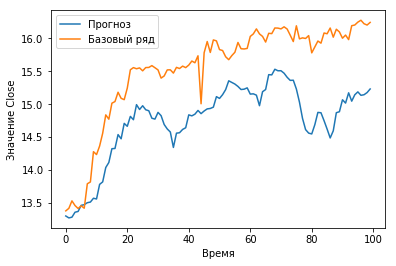

In [0]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

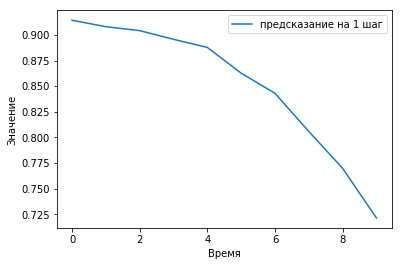

In [0]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

#ModelX2
**Сложная сеть из LSTM, Conv1D и Dense слоёв на старте и Dense слоёв в конце**

*Разбор данного раздела:* https://youtu.be/1BV1I59HwB4?t=5732

In [0]:
dataInput = Input(shape=(xTrain.shape[1], xTrain.shape[2]))

lstmWay = CuDNNLSTM(40, return_sequences="True")(dataInput)
lstmWay = CuDNNLSTM(40, return_sequences="True")(lstmWay)

convWay = Conv1D(100, 5, activation="relu")(dataInput)
convWay = Conv1D(100, 5, activation="relu")(convWay)

denseWay = Dense(4, activation="linear")(dataInput)
denseWay = Dense(4, activation="linear")(denseWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
denseWay = Flatten()(denseWay)

finWay = concatenate([lstmWay, convWay, denseWay])
finWay = Dense(100, activation="linear")(finWay)
finWay = Dense(10, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX2 = Model(dataInput, finWay)

modelX2.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelX2.fit(xTrain, 
                    yTrain, 
                    epochs=80, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'][10:], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Точность на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

#Сохранение и загрузка сети

In [0]:
modelX2.save("modelX2.h5")

In [0]:
!ls

In [0]:
files.download("modelX2.h5")

In [0]:
files.upload()
!ls

Saving modelX2.h5 to modelX2.h5
2004-2019.tsv  modelX2.h5  sample_data


In [0]:
modelX2Loaded = load_model('modelX2.h5')

In [0]:
print(modelX2Loaded.summary())

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 20, 6)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_63 (CuDNNLSTM)       (None, 20, 40)       7680        input_26[0][0]                   
__________________________________________________________________________________________________
conv1d_56 (Conv1D)              (None, 16, 100)      3100        input_26[0][0]                   
__________________________________________________________________________________________________
dense_173 (Dense)               (None, 20, 100)      700         input_26[0][0]                   
___________________________________________________________________________________________

In [0]:
#Прогнозируем данные текущей сетью
currModel = modelX2
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

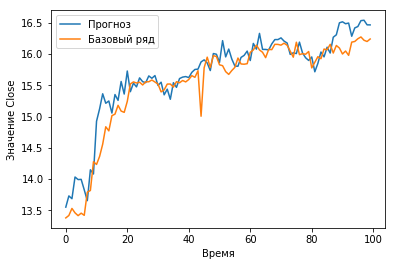

In [0]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

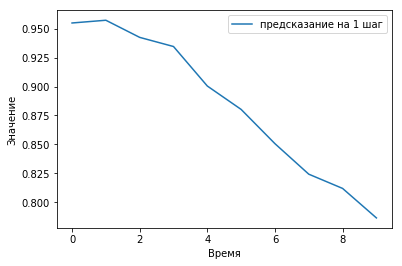

In [0]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

#Прогнозирование на несколько шагов вперёд

*Разбор данного раздела:* https://youtu.be/1BV1I59HwB4?t=5806

In [0]:
#Задаём параметры загрузки данных
xLen = 20
stepsForward = 10
xChannels = range(data.shape[1])
yChannels = [0]
xNormalization = 0
yNormalization = 0
valLen = 100
returnFlatten = 1
convertToDerivative = 0

#Загружаем данные
(xTrain2, yTrain2), (xVal2, yVal2), (xScaler2, yScaler2) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Отображаем размерности данных для проверки
print(xTrain2.shape)
print(yTrain2.shape)
print(xVal2.shape)
print(yVal2.shape)

(622, 120)
(622, 10)
(100, 120)
(100, 10)


**Обучаем полносвязную сеть**

*Разбор данного раздела:* https://youtu.be/1BV1I59HwB4?t=5842








Train on 622 samples, validate on 100 samples
Epoch 1/200





622/622 [==============================] - 10s 16ms/step - loss: 1.8999 - val_loss: 12.4273
Epoch 2/200
622/622 [==============================] - 0s 200us/step - loss: 1.5556 - val_loss: 9.9229
Epoch 3/200
622/622 [==============================] - 0s 158us/step - loss: 1.2772 - val_loss: 7.9687
Epoch 4/200
622/622 [==============================] - 0s 170us/step - loss: 1.0508 - val_loss: 6.3408
Epoch 5/200
622/622 [==============================] - 0s 200us/step - loss: 0.8673 - val_loss: 5.0828
Epoch 6/200
622/622 [==============================] - 0s 194us/step - loss: 0.7206 - val_loss: 4.0516
Epoch 7/200
622/622 [==============================] - 0s 206us/step - loss: 0.6021 - val_loss: 3.2085
Epoch 8/200
622/622 [==============================] - 0s 204us/step - loss: 0.5041 - val_loss: 2.5552
Epoch 9/200
622/622 [==============================] - 0s 178us/step - loss: 0.4259 - val_loss: 1.9926
Epoch 10/200
6

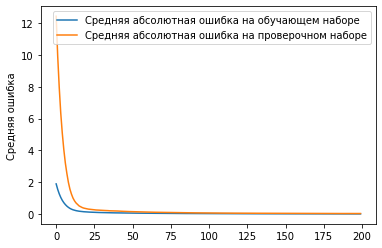

In [0]:
modelD2 = Sequential()

modelD2.add(Dense(100, input_dim = xTrain2.shape[1], activation="linear"))
modelD2.add(Dense(100, activation="linear"))
modelD2.add(Dense(100, activation="linear"))
modelD2.add(Dense(yTrain2.shape[1], activation="linear"))

modelD2.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelD2.fit(xTrain2, 
                    yTrain2, 
                    epochs=200,
                    batch_size=20, 
                    verbose=1, 
                    validation_data=(xVal2, yVal2))

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

**Отображаем результаты**

*Разбор данного раздела:* https://youtu.be/1BV1I59HwB4?t=5883

In [0]:
#Прогнозируем данные текущей сетью
currModel = modelD2
(predVal2, yValUnscaled2) = getPred(currModel, xVal2, yVal2, yScaler2)

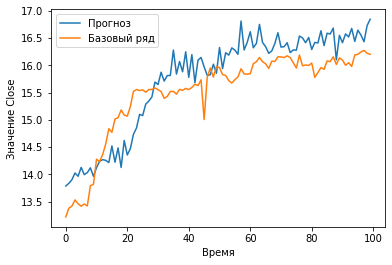

In [0]:
#Отображаем графики
showPredict(0, 100, 9, predVal2, yValUnscaled2)

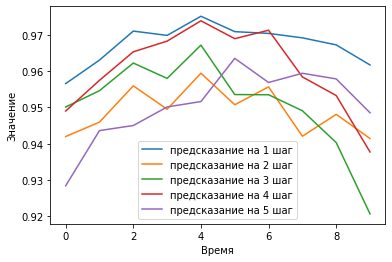

In [0]:
#Отображаем корреляцию
showCorr([0, 1, 2, 3, 4], 10, predVal2, yValUnscaled2)

#Сложная модель. Предсказание на несколько шагов

*Разбор данного раздела:* https://youtu.be/1BV1I59HwB4?t=6043

**Загружаем данные**

In [0]:
xLen = 20
stepsForward = 10
xChannels = range(data.shape[1])
yChannels = [0]
xNormalization = 0
yNormalization = 0
valLen = 100
returnFlatten = 0

(xTrain3, yTrain3), (xVal3, yVal3), (xScaler3, yScaler3) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, 0)

print(xTrain3.shape)
print(yTrain3.shape)
print(xVal3.shape)
print(yVal3.shape)

(622, 20, 6)
(622, 10)
(100, 20, 6)
(100, 10)


**Обучаем нейронку**

Train on 622 samples, validate on 100 samples
Epoch 1/100
622/622 [==============================] - 6s 10ms/step - loss: 0.6190 - val_loss: 5.4115
Epoch 2/100
622/622 [==============================] - 0s 436us/step - loss: 0.5150 - val_loss: 4.9660
Epoch 3/100
622/622 [==============================] - 0s 458us/step - loss: 0.4364 - val_loss: 4.5491
Epoch 4/100
622/622 [==============================] - 0s 507us/step - loss: 0.3740 - val_loss: 4.2007
Epoch 5/100
622/622 [==============================] - 0s 457us/step - loss: 0.3208 - val_loss: 3.8602
Epoch 6/100
622/622 [==============================] - 0s 540us/step - loss: 0.2758 - val_loss: 3.5538
Epoch 7/100
622/622 [==============================] - 0s 518us/step - loss: 0.2365 - val_loss: 3.2763
Epoch 8/100
622/622 [==============================] - 0s 511us/step - loss: 0.2023 - val_loss: 3.0071
Epoch 9/100
622/622 [==============================] - 0s 486us/step - loss: 0.1726 - val_loss: 2.7685
Epoch 10/100
622/622 [======

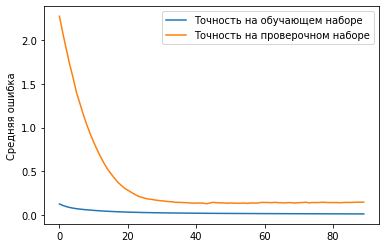

In [0]:
dataInput = Input(shape=(xTrain3.shape[1], xTrain3.shape[2]))

lstmWay = CuDNNLSTM(40, return_sequences="True")(dataInput)
convWay = Conv1D(100, 5, activation="relu")(dataInput)

lstmWay = CuDNNLSTM(40, return_sequences="True")(lstmWay)
convWay = Conv1D(100, 5, activation="relu")(convWay)

denseWay = Dense(10, activation="linear")(dataInput)
denseWay = Dense(10, activation="linear")(denseWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
denseWay = Flatten()(denseWay)

finWay = concatenate([lstmWay, convWay, denseWay])
finWay = Dense(10, activation="linear")(finWay)
finWay = Dense(yTrain3.shape[1], activation="linear")(finWay)

modelX3 = Model(dataInput, finWay)

modelX3.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelX3.fit(xTrain3, 
                    yTrain3, 
                    epochs=100, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal3, yVal3))

plt.plot(history.history['loss'][10:], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Точность на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

**Отображаем реультаты**

In [0]:
#Прогнозируем данные текущей сетью
currModel = modelX3
(predVal3, yValUnscaled3) = getPred(currModel, xVal3, yVal3, yScaler3)

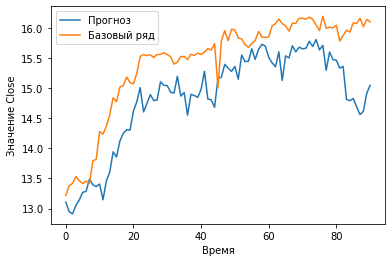

In [0]:
#Отображаем графики
showPredict(9, 100, 0, predVal3, yValUnscaled3)

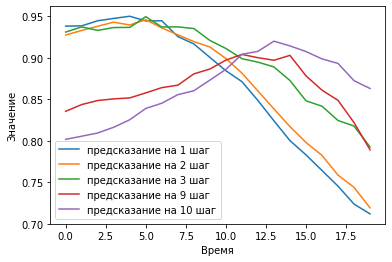

In [0]:
#Отображаем корреляцию
showCorr([0, 1, 2, 8, 9], 20, predVal3, yValUnscaled3)

#Своя функция ошибки

*Разбор данного раздела:* https://youtu.be/1BV1I59HwB4?t=6146

In [0]:
### Функция ошибки
def getError(x1, x2):
  dx = (x1-x2) ** 2 #Вычислем среднеквадратичную ошибку по точкам
  dxs = np.sort(dx)[::-1] #Сортируем ошибку в порядке убывания
  return np.mean(dxs[:10]) #Итоговая ошибка равны среднему 10 самых больших ошибок на всём отрезке

In [0]:
#Вычисляем ошибку при прогнозе на 1 шаг
predictionStep = 0
x1 = predVal2[:,predictionStep]
x2 = yValUnscaled2[:,predictionStep]

print(getError(x1, x2))

0.32653351332014435


In [0]:
#Отображаем ошибку при прогнозе на несколько шагов вперёд
for i in range(stepsForward):
  x1 = predVal2[:,i]
  x2 = yValUnscaled2[:,i]

  print("Шаг", i+1, "ошибка", round(getError(x1, x2),3))

Шаг 1 ошибка 0.327
Шаг 2 ошибка 0.742
Шаг 3 ошибка 0.562
Шаг 4 ошибка 0.89
Шаг 5 ошибка 0.845
Шаг 6 ошибка 0.984
Шаг 7 ошибка 0.892
Шаг 8 ошибка 0.97
Шаг 9 ошибка 0.662
Шаг 10 ошибка 0.684


In [0]:
### Функция ошибки

def getError2(x1, x2):
  corr = []
  yLen = x1.shape[0]

  #Вычисляем корреляцию выхода сети в верным ответом
  #Смещая выход сети назад от 0 до 9 шагов
  for i in range(10):
    corr.append(correlate(x1[:yLen-i], x2[i:]))
  
  corr = np.array(corr)
  
  #Возвращаем функцию ошибки, как произведение
  #1 - корреляции без смещения (со смещением на 0)
  #2 - того, во сколько раз корреляция без смещения больше, чем средняя корреляция при смещении на 1-5 шагов
  return corr[0] * (corr[0] / np.max(corr[1:10]))

In [0]:
#Вычисляем ошибку при прогнозе на 1 шаг
predictionStep = 0
x1 = predVal2[:,predictionStep]
x2 = yValUnscaled2[:,predictionStep]

print(getError2(x1, x2))

0.9674742907948463


In [0]:
#Отображаем ошибку при прогнозе на несколько шагов вперёд
for i in range(stepsForward):
  x1 = predVal2[:,i]
  x2 = yValUnscaled2[:,i]

  print(round(getError2(x1, x2),4))

0.9675
0.9544
0.9601
0.9512
0.9322
0.9158
0.9012
0.8866
0.9137
0.9138


In [0]:
#Сравнимаем две модели по новой функции ошибки
#При предсказании на несколько шагов вперёд
model1 = modelX3
model2 = modelD2

#Получаем предсказания от обеих сетей
predValM1 = yScaler3.inverse_transform(model1.predict(xVal3))
predValM2 = yScaler2.inverse_transform(model2.predict(xVal2))
yValUnscaled3 = yScaler3.inverse_transform(yVal2)

#Здаём собственную функцию ошибки
errorFunc = getError2

for i in range(stepsForward):
  x1 = predValM1[:,i]
  x2 = predValM2[:,i]
  x = yValUnscaled2[:,i]

  print("Предсказание на", i+1, "шагов: M1 =", round(errorFunc(x1, x),3), "M2 =", round(errorFunc(x2, x),3))

Предсказание на 1 шагов: M1 = 0.94 M2 = 0.977
Предсказание на 2 шагов: M1 = 0.96 M2 = 0.951
Предсказание на 3 шагов: M1 = 0.943 M2 = 0.938
Предсказание на 4 шагов: M1 = 0.95 M2 = 0.924
Предсказание на 5 шагов: M1 = 0.949 M2 = 0.951
Предсказание на 6 шагов: M1 = 0.869 M2 = 0.936
Предсказание на 7 шагов: M1 = 0.9 M2 = 0.897
Предсказание на 8 шагов: M1 = 0.876 M2 = 0.929
Предсказание на 9 шагов: M1 = 0.89 M2 = 0.917
Предсказание на 10 шагов: M1 = 0.879 M2 = 0.892
